In [1]:
import pyzed.sl as sl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
svo_path = '../data/Schlieren_20230913/HD1080_SN35520970_11-03-24.svo'

In [3]:
zed = sl.Camera()

# init parameters
init_params = sl.InitParameters()
init_params.set_from_svo_file(svo_path)
init_params.depth_mode = sl.DEPTH_MODE.ULTRA
init_params.coordinate_units = sl.UNIT.METER
init_params.depth_maximum_distance = 40
init_params.depth_minimum_distance = 1
init_params.sdk_verbose = True

zed.open(init_params)

SUCCESS

In [4]:
calibration_frames = 30
skip_frames = 25

In [5]:
runtime_parameters = sl.RuntimeParameters()
temp_image_left = sl.Mat()
temp_image_right = sl.Mat()

In [6]:
color_array_l = np.zeros((1080, 1920, 3, calibration_frames))
color_array_r = np.zeros((1080, 1920, 3, calibration_frames))

In [7]:
for i in range(calibration_frames * skip_frames):
    zed.grab(runtime_parameters)
    if i % skip_frames != 0:
        continue
    frame_nr = zed.get_svo_position()
    # zed.retrieve_measure(image, sl.MEASURE.DEPTH)
    zed.retrieve_image(temp_image_left, sl.VIEW.LEFT)
    current_frame_l = temp_image_left.get_data()[:, :, :3]
    color_array_l[:, :, :, i // skip_frames] = current_frame_l
    zed.retrieve_image(temp_image_right, sl.VIEW.RIGHT)
    current_frame_r = temp_image_right.get_data()[:, :, :3]
    color_array_r[:, :, :, i // skip_frames] = current_frame_r

In [8]:
# get median depth
median_depth_l = np.nanmedian(color_array_l, axis=3)
median_depth_r = np.nanmedian(color_array_r, axis=3)

In [9]:
print(median_depth_l.shape)
print(median_depth_r.shape)

(1080, 1920, 3)
(1080, 1920, 3)


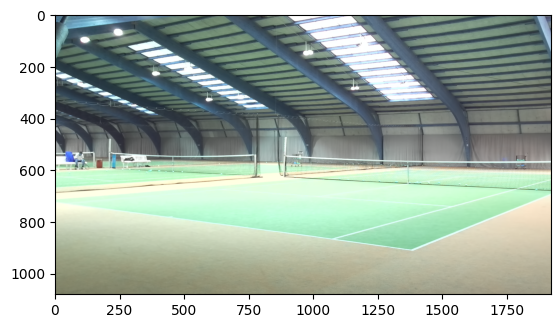

In [10]:
plt.imshow(median_depth_l.astype(np.uint8))

In [11]:
image_left = sl.Mat()
image_right = sl.Mat()
depth = sl.Mat()

In [12]:
# init detection parameters
detection_parameters = sl.ObjectDetectionParameters()

detection_parameters.image_sync = True
detection_parameters.enable_tracking = True
detection_parameters.enable_segmentation = True

detection_parameters.detection_model = sl.OBJECT_DETECTION_MODEL.MULTI_CLASS_BOX_MEDIUM

if detection_parameters.enable_tracking:
    zed.enable_positional_tracking()

zed.enable_object_detection(detection_parameters)

detection_confidence = 20
detection_parameters_rt = sl.ObjectDetectionRuntimeParameters(detection_confidence)

detection_parameters_rt.object_class_filter = [sl.OBJECT_CLASS.PERSON, sl.OBJECT_CLASS.SPORT]

detected_objects = sl.Objects()

In [13]:
# create a mask for the detected object
def get_mask(index, image):
    mask = np.zeros_like(image)

    # get the bounding box
    bb = detected_objects.object_list[index].bounding_box_2d

    # extend the bounding box by 10 pixels
    bb[0, :] -= 10
    bb[1, :] += 10
    bb[2, :] += 10
    bb[3, :] -= 10

    # get the mask
    mask[int(bb[0, 1]):int(bb[2, 1]), int(bb[0, 0]):int(bb[1, 0])] = 1

    return mask

In [14]:
from scipy.ndimage import maximum_position, uniform_filter, binary_dilation

def detect_tennis_ball(moving_pixels, depth_pixels, detected_objects):
    diff_pixels = np.square(moving_pixels.astype(np.uint8)).sum(axis=2)

    diff_normalized = (diff_pixels / diff_pixels.max()).round()

    masked = diff_normalized
    for i in range(len(detected_objects.object_list)):
        mask = get_mask(i, diff_normalized)
        masked = masked - mask

    masked = masked - (1 - np.isnan(depth_pixels.numpy()))

    masked[masked < 0] = 0

    # set 100 pixels from border to 0
    masked[:100, :] = 0
    masked[-100:, :] = 0
    masked[:, :100] = 0
    masked[:, -100:] = 0
    
    dilated = binary_dilation(masked, iterations=1)
    
    filtered = uniform_filter(dilated, size=4)

    return maximum_position(filtered)

In [ ]:
# draw the bounding box 10 pixels around the center
def draw_bb(image, center):
    bb = np.zeros_like(image)
    bb[center[0] - 15:center[0] + 15, center[1] - 15:center[1] + 15] = 255
    # add blue and green channel
    bb[:, :, 1] = np.zeros_like(bb[:, :, 0])
    bb[:, :, 2] = bb[:, :, 1]
    return bb

In [ ]:
for i in range(10):
    zed.grab(runtime_parameters)

In [ ]:
zed.retrieve_image(image_left, sl.VIEW.LEFT)
zed.retrieve_image(image_right, sl.VIEW.RIGHT)
zed.retrieve_measure(depth, sl.MEASURE.DEPTH)
current_frame_left = image_left.get_data()[:, :, :3]
current_frame_right = image_right.get_data()[:, :, :3]
zed.retrieve_objects(detected_objects, detection_parameters_rt)

SUCCESS

In [ ]:
moving_left = current_frame_left - median_depth_l
moving_right = current_frame_right - median_depth_r

In [ ]:
tennis_ball_pos = detect_tennis_ball(moving_left, depth, detected_objects)

In [ ]:
tennis_ball_pos

(559, 1561)

In [ ]:
tennis_ball_pos_r = detect_tennis_ball(moving_right, depth, detected_objects)

In [ ]:
tennis_ball_pos_r

(586, 1181)

In [ ]:
tennis_ball_bb = draw_bb(current_frame_left, tennis_ball_pos)

In [ ]:
tennis_ball_bb_r = draw_bb(current_frame_right, tennis_ball_pos)

In [ ]:
frame_with_bb = tennis_ball_bb.copy()
frame_with_bb[tennis_ball_bb != 255] = current_frame_left[tennis_ball_bb != 255]

In [ ]:
frame_with_bb_r = tennis_ball_bb_r.copy()
frame_with_bb_r[tennis_ball_bb_r != 255] = current_frame_right[tennis_ball_bb_r != 255]

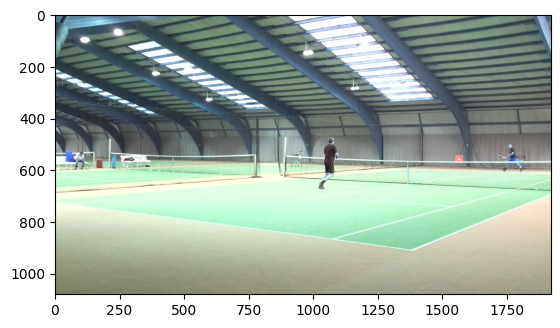

In [ ]:
plt.imshow(frame_with_bb)

In [ ]:
tennis_ball_pos

(505, 0)